# Training MAPE

This notebook discusses challenges in training untypical loss functions such as weighted MAE, MAPE etc

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras import regularizers
from keras.losses import mean_absolute_percentage_error, mean_squared_error
from keras import backend as K

## Data Set

We will fit linear models to the following data

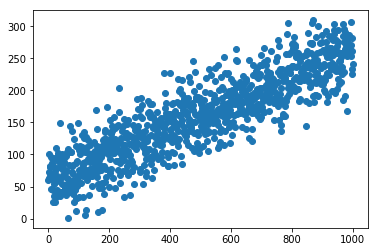

In [3]:
## a rising trend + some noise

X = np.linspace(0,1000,1000)
y = np.random.normal(60,30,1000)+0.2*X
y = np.stack([y,np.zeros(y.shape)]).max(0)+1
plt.scatter(X,y)

## MAPE vs RMSE

While RMSE quantifies the absolute deviation of predictions, MAPE cares about the relative error.

$$
MAPE = 100\cdot \sum_i \frac{\left|y^{i}_{pred}-y^{i}_{true}\right|}{\left|y^{i}_{true}\right|} \\
RMSE = \sum_i \left(y^{i}_{pred}-y^{i}_{true}\right)^2
$$

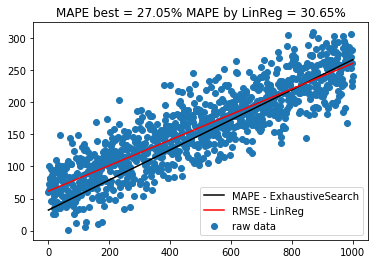

Best MAPE weights: w0=0.235 w1=32.000


In [4]:
def fit_mape(w,X,y):
    ''' given a grid of model weights, inputs and targets computes predictions, residuals and mape scores '''

    # predictions on the grid
    y_pred = np.expand_dims(w[:,:,0],2)*np.expand_dims(X[:,0],0)
    y_pred = y_pred + np.expand_dims(w[:,:,1],2)*np.expand_dims(X[:,1],0)

    # residuals
    res = (y_pred-y.reshape(1,1,-1))/y.reshape(1,1,-1)

    # scores
    mape_out = np.abs(res).mean(2)

    return y_pred,res,mape_out

X_t = np.stack([X,np.ones(X.shape[0])],1)
y_t = y.reshape(-1,1)

# build the grid, fit the model and plot
w1,w2=np.meshgrid(np.linspace(0,1,99),np.linspace(0,100,101),indexing='ij')
w=np.stack([w1,w2],axis=2) # shape = (99,101,2)
_,_,mape_out = fit_mape(w,X_t,y_t)

plt.scatter(X,y,label='raw data')
best_idx = mape_out.ravel().argmin()
best_w1 = w1.ravel()[best_idx]
best_w2 = w2.ravel()[best_idx]
y_pred = X_t.dot(np.array([best_w1,best_w2]))
plt.plot(X,y_pred,label='MAPE - ExhaustiveSearch',color='black')
reg = linear_model.LinearRegression(fit_intercept=False).fit(X_t,y_t)
plt.plot(X,reg.predict(X_t),label='RMSE - LinReg',color='red')

mape_rmse = np.abs( (reg.predict(X_t)-y_t)/y_t ).mean()
plt.title('MAPE best = %s%% MAPE by LinReg = %s%%'%((100*mape_out.ravel()[best_idx]).round(2),(100*mape_rmse).round(2)))
plt.legend()
plt.show()

print('Best MAPE weights: w0={:.3f} w1={:.3f}'.format(w1.ravel()[best_idx],w2.ravel()[best_idx]))

## MAPE Surface - Optimization Issues

Let's plot the surface of the loss function. Note that the minimum corresponds to the point (w0,w1) found above.

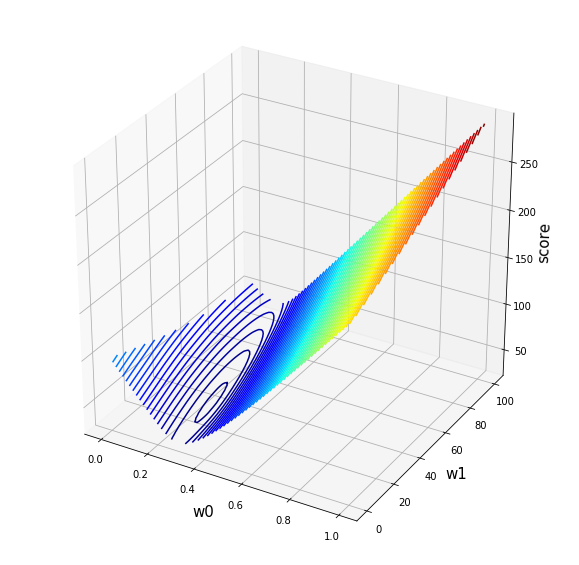

In [5]:
def plot_surface(weights,scores):
    ''' plots the surface given grid of kernel weights and mape scores '''

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.contour3D(weights[:,:,0],weights[:,:,1],100*scores.reshape(weights[:,:,0].shape),75,cmap='jet')
    ax.set_xlabel('w0',fontsize=15)
    ax.set_ylabel('w1',fontsize=15)
    ax.set_zlabel('score',fontsize=15)
    plt.show()
    
plot_surface(w,mape_out)

The surface changes much differently in each of directions w0,w1. 
This will be the issue for optimization 
<ul>
<li>gradients will be on very different scales</li>
<li>initial distance to the optimum may be large</li>
</ul>

In [6]:
class FillTensors(keras.callbacks.Callback):
    ''' memorizes values for given tensors, per each epoch'''
    
    def __init__(self,tens,model,X_t,y_t):
        self.tens_ = tens
        self.tens_vals_ = []
        self.model_ = model
        self.X_t_ = X_t
        self.y_t_ = y_t
        super(FillTensors).__init__()
    
    def on_epoch_end(self, batch, logs=None):
        val=K.get_session().run(self.tens_,feed_dict={self.model_.sample_weights[0]:[1],
                          self.model_.inputs[0]:self.X_t_,
                          self.model_.targets[0]:self.y_t_
                         })
        self.tens_vals_.append(val)

def get_model(optimizer=None,kernel_regularizer=None):        
    model = Sequential()
    model.add(Dense(1,input_dim=2,
                    activation='linear',
                    use_bias = False,
                    kernel_regularizer = kernel_regularizer,
            ))
    model.compile(optimizer = optimizer, loss = mean_absolute_percentage_error, metrics=[mean_absolute_percentage_error])
    return model

## see that gradients are on very different scales !!!

K.clear_session()
model = get_model(Adam())
loss_grads = K.gradients(model.total_loss,model.trainable_weights)
callback = FillTensors(loss_grads,model,X_t,y_t)
model.fit(X_t,y_t,verbose=2,epochs=5,batch_size=1024,shuffle=True,callbacks=[callback])

print('Gradients \n%s'%[g[0].ravel() for g in callback.tens_vals_[-3:]])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 0s - loss: 345.7510 - mean_absolute_percentage_error: 345.7510
Epoch 2/5
 - 0s - loss: 345.5255 - mean_absolute_percentage_error: 345.5255
Epoch 3/5
 - 0s - loss: 345.2653 - mean_absolute_percentage_error: 345.2653
Epoch 4/5
 - 0s - loss: 344.9896 - mean_absolute_percentage_error: 344.9896
Epoch 5/5
 - 0s - loss: 344.7052 - mean_absolute_percentage_error: 344.7052
Gradients 
[array([-302.1197   ,   -0.9216369], dtype=float32), array([-302.1197   ,   -0.9216369], dtype=float32), array([-302.1197   ,   -0.9216369], dtype=float32)]


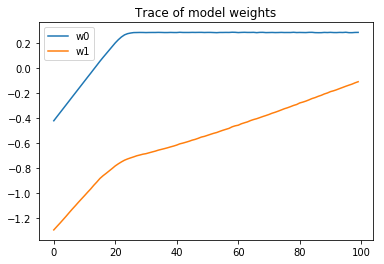

In [7]:
## see that the second coef does not converge well

K.clear_session()
model = get_model(Adam())
coefs = model.trainable_weights
callback = FillTensors(coefs,model,X_t,y_t)
_ = model.fit(X_t,y_t,verbose=0,epochs=100,batch_size=32,shuffle=True,callbacks=[callback])

vals = np.array(callback.tens_vals_).reshape(100,2)
plt.plot(vals[:,0],label='w0')
plt.plot(vals[:,1],label='w1')
plt.legend()
plt.title('Trace of model weights')
plt.show()

## Scale and Optimize !

We scale the inputs looking at the loss formula. We have

$$ 
\begin{align}
MAPE = \frac{100}{n}\sum_i \left| 1-\frac{y^{i}_{pred}}{y^{i}_{true}}\right| \\
y_{pred} = X \cdot \mathbf{w}
\end{align}
$$

Since we essentially want $\frac{X}{y}\cdot \mathbf{w} \approx 1$ we propose to normalize so that 
$\frac{1}{n}\sum_{i} \left| X^{(i)}/y^{(i)}\right|\approx \mathbf{1}$ (column-wise).

Note the normalization takes not only inputs but also targets, as the problem is weighted.

This keeps the gradients (actually: subgradients) bounded by 100, we also expect the weights to be bounded (by 1 or little more). 

We can also see that the optimization surface improved.

With this in mind can set a constant step size accordingly
https://web.stanford.edu/class/ee392o/subgrad_method.pdf

Scaling factor = [302.12    0.922]


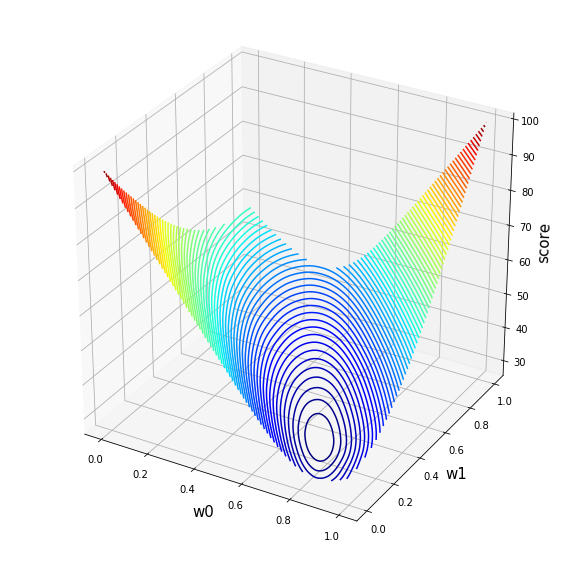

In [8]:
## now do scaling !
scale_X = np.abs(X_t/y_t).mean(0)
#scale_X = ((X_t/y_t)**2).mean(0)**0.5
#scale_X = np.array([200,1])#/100
print('Scaling factor = %s'%(scale_X*100).round(3)) # the loss in keras is multiplied by 100
X_t1 = X_t/scale_X 

## search the best model on the updated scale  
w1,w2=np.meshgrid(np.linspace(0,1,99),np.linspace(0,1,101),indexing='ij')
w=np.stack([w1,w2],axis=2) # shape = (99,101,2)
_,_,mape_out = fit_mape(w,X_t1,y_t)

plot_surface(w,mape_out)

Once the scale is fixed, the model converges to the solution!

In [9]:
## train the model, the gradients have comparable magnitudes and convergence is OK !!!

K.clear_session()
model = get_model(SGD(1e-5))
loss_grads = K.gradients(model.total_loss,model.trainable_weights)
callback = FillTensors(loss_grads,model,X_t1,y_t)
_ = model.fit(X_t1,y_t,verbose=2,epochs=200,batch_size=32,shuffle=True,callbacks=[callback])

print('Gradients')
print(np.array([g[0].ravel() for g in callback.tens_vals_[:5]]).round(3))

print('Solution')
w1,w2 = K.get_session().run(model.trainable_weights)[0].ravel()/scale_X
print('Best MAPE weights (by SGD): w0={:.3f} w1={:.3f}'.format(w1,w2))

Epoch 1/200
 - 0s - loss: 42.5933 - mean_absolute_percentage_error: 42.5933
Epoch 2/200
 - 0s - loss: 40.6027 - mean_absolute_percentage_error: 40.6027
Epoch 3/200
 - 0s - loss: 38.8788 - mean_absolute_percentage_error: 38.8788
Epoch 4/200
 - 0s - loss: 37.4043 - mean_absolute_percentage_error: 37.4043
Epoch 5/200
 - 0s - loss: 36.1002 - mean_absolute_percentage_error: 36.1002
Epoch 6/200
 - 0s - loss: 34.9362 - mean_absolute_percentage_error: 34.9362
Epoch 7/200
 - 0s - loss: 33.8824 - mean_absolute_percentage_error: 33.8824
Epoch 8/200
 - 0s - loss: 33.0006 - mean_absolute_percentage_error: 33.0006
Epoch 9/200
 - 0s - loss: 32.1959 - mean_absolute_percentage_error: 32.1959
Epoch 10/200
 - 0s - loss: 31.5544 - mean_absolute_percentage_error: 31.5544
Epoch 11/200
 - 0s - loss: 30.9795 - mean_absolute_percentage_error: 30.9795
Epoch 12/200
 - 0s - loss: 30.4927 - mean_absolute_percentage_error: 30.4927
Epoch 13/200
 - 0s - loss: 30.0988 - mean_absolute_percentage_error: 30.0988
Epoch 14

Epoch 108/200
 - 0s - loss: 27.1062 - mean_absolute_percentage_error: 27.1062
Epoch 109/200
 - 0s - loss: 27.0992 - mean_absolute_percentage_error: 27.0992
Epoch 110/200
 - 0s - loss: 27.0997 - mean_absolute_percentage_error: 27.0997
Epoch 111/200
 - 0s - loss: 27.0928 - mean_absolute_percentage_error: 27.0928
Epoch 112/200
 - 0s - loss: 27.0922 - mean_absolute_percentage_error: 27.0922
Epoch 113/200
 - 0s - loss: 27.0880 - mean_absolute_percentage_error: 27.0880
Epoch 114/200
 - 0s - loss: 27.0890 - mean_absolute_percentage_error: 27.0890
Epoch 115/200
 - 0s - loss: 27.0881 - mean_absolute_percentage_error: 27.0881
Epoch 116/200
 - 0s - loss: 27.0885 - mean_absolute_percentage_error: 27.0885
Epoch 117/200
 - 0s - loss: 27.0853 - mean_absolute_percentage_error: 27.0853
Epoch 118/200
 - 0s - loss: 27.0807 - mean_absolute_percentage_error: 27.0807
Epoch 119/200
 - 0s - loss: 27.0872 - mean_absolute_percentage_error: 27.0872
Epoch 120/200
 - 0s - loss: 27.0833 - mean_absolute_percentage_e